In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from lightgbm import LGBMClassifier
from category_encoders import CatBoostEncoder

from galileo.feature_selection import IterativeFeatureSelection, OneShotFeatureSelection
from galileo.assistant import Assistant

In [2]:
X, y = make_classification(
    n_samples=200_000,
    n_features=500,
    n_clusters_per_class=1,
    n_informative=150,
    random_state=42,
)

df = pd.DataFrame(X, columns=[f"var_{x}" for x in range(0, len(X[0]))])
df['target'] = y



In [3]:
assist = Assistant(dataframe=df)
df = assist.check_duplicates(keys=['var_1', 'var_2'])

No duplications found for given keys


In [4]:
sample = df.sample(n=5_000, random_state=42)

X = sample.drop('target', axis=1)
y = sample['target']
features = X.columns.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [5]:
model = Pipeline(
            [
                ("encoder", CatBoostEncoder(random_state=42)),
                ("estimator", LGBMClassifier(random_state=42, verbosity=-1)),
            ]
)

In [6]:
selector = OneShotFeatureSelection(model, 
                                    X_train, 
                                    y_train, 
                                    X_test, 
                                    y_test, 
                                    features, 
                                    target_name='target',
                                    metric='roc_auc')

In [7]:
initial_selection = selector.select_features()

Number of initial features selected: 130
26.0% of total features.
Scores with all features: 0.99
Scores with selected features: 0.989
Loss is 0.0%


In [8]:
selector = IterativeFeatureSelection(model[-1], 
                                    X_train, 
                                    y_train, 
                                    X_test, 
                                    y_test, 
                                    initial_selection, 
                                    target_name='target', 
                                    threshold=0.02, 
                                    metric='roc_auc')

Building score-feature tradeoff curve
Fitting model...


100%|██████████| 100/100 [00:32<00:00,  3.12it/s]

Done!
Found a score with a delta of 0.0189
Highest score is 0.9894698945666949
Optimal % of features is: 56 (73 features)
Score for metric roc_auc: 0.970741706770508


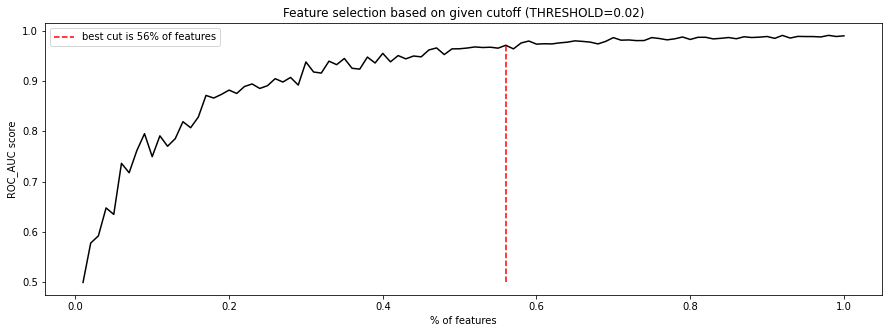

In [9]:
final_selection = selector.select_features()